In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

In [2]:
csv_path = '/Users/admin/Documents/School/BS-CSE/Thesis/extrapolation/blast_sensors_2023-07-21 00_00_00_2023-07-25 00_00_00.csv'
df = pd.read_csv(csv_path)

df = df.iloc[:,1:]


df.drop(['datetime', 'location', 'expt_num'], axis=1, inplace=True)


df.head()

,type,index,value
0,temperature,0,28.775000
1,temperature,1,27.875000
2,humidity,0,86.880000
3,humidity,1,84.160000
4,light_intensity,0,779.666667


In [3]:
df['type'].value_counts()

light_intensity    576
soil_moisture      576
temperature        128
humidity           128
solution_pH         64
solution_EC         64
Name: type, dtype: int64

In [4]:
sensor_types = pd.unique(df['type'])
sensor_types

array(['temperature', 'humidity', 'light_intensity', 'soil_moisture',
       'solution_pH', 'solution_EC'], dtype=object)

In [5]:
DATA_PER_SENSOR = sum(df['type'] == 'solution_pH')

for type in sensor_types:
    mask = df['type'] == type
    print(f"{type}: {df[mask].shape[0] / DATA_PER_SENSOR:.2f} sensors")

temperature: 2.00 sensors
humidity: 2.00 sensors
light_intensity: 9.00 sensors
soil_moisture: 9.00 sensors
solution_pH: 1.00 sensors
solution_EC: 1.00 sensors


In [6]:
sensor_dict = {}
for typ in sensor_types:
    _sensor = df.loc[df['type'] == typ] # select what type of sensor
    
    for ind in pd.unique(_sensor['index']): # select ith sensor
        sensor_dict[f'{typ}_{ind}'] = _sensor.loc[_sensor['index'] == ind]['value'].values
        print(f"{typ}_{ind}: {_sensor.loc[_sensor['index'] == ind]['value'].isna().sum()} nan values")

temperature_0: 0 nan values
temperature_1: 0 nan values
humidity_0: 0 nan values
humidity_1: 0 nan values
light_intensity_0: 0 nan values
light_intensity_1: 0 nan values
light_intensity_2: 0 nan values
light_intensity_3: 0 nan values
light_intensity_4: 0 nan values
light_intensity_5: 0 nan values
light_intensity_6: 0 nan values
light_intensity_7: 0 nan values
light_intensity_8: 0 nan values
soil_moisture_0: 0 nan values
soil_moisture_1: 0 nan values
soil_moisture_2: 0 nan values
soil_moisture_3: 0 nan values
soil_moisture_4: 0 nan values
soil_moisture_5: 0 nan values
soil_moisture_6: 0 nan values
soil_moisture_7: 0 nan values
soil_moisture_8: 0 nan values
solution_pH_0: 0 nan values
solution_EC_0: 0 nan values


In [7]:
#sensor_df = pd.DataFrame.from_dict(data=sensor_dict)
# since the dict values dont have equal length, use this instead
sensor_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in sensor_dict.items() ]))
sensor_df.head() # check first 5 rows

,temperature_0,temperature_1,humidity_0,humidity_1,light_intensity_0,light_intensity_1,light_intensity_2,light_intensity_3,light_intensity_4,light_intensity_5,...,soil_moisture_1,soil_moisture_2,soil_moisture_3,soil_moisture_4,soil_moisture_5,soil_moisture_6,soil_moisture_7,soil_moisture_8,solution_pH_0,solution_EC_0
0,28.775,27.875,86.88,84.16,779.666667,519.166667,565.833333,535.750000,801.000000,387.333333,...,0.830777,0.621145,1.0,0.859257,1.0,0.773761,0.661958,0.391568,3.403628,0.995702
1,31.060,30.040,83.00,78.48,912.916667,592.416667,1973.833333,930.333333,2643.333333,4278.500000,...,0.843214,0.609999,1.0,0.840397,1.0,0.772066,0.650872,0.368084,3.401689,1.118414
2,30.380,30.040,86.00,76.00,755.416667,527.416667,731.000000,542.250000,823.750000,677.750000,...,0.833995,0.615449,1.0,0.836982,1.0,0.765059,0.655196,0.370144,3.401870,1.157004
3,30.900,31.180,86.12,71.48,746.250000,527.333333,651.250000,537.333333,802.666667,562.500000,...,0.839867,0.608664,1.0,0.824730,1.0,0.753250,0.644340,0.360977,3.401124,1.184810
4,31.200,31.480,85.32,71.36,713.666667,498.250000,585.000000,502.333333,760.083333,494.583333,...,0.876201,0.617384,1.0,0.815448,1.0,0.763590,0.656254,0.356238,3.400672,1.156288


In [8]:
sensor_df.shape

(64, 24)

In [9]:
assert not sensor_df.isnull().any().any(), "sensor_df still contains  nans" # raise an error if there's still nans

## Averaging sensor types

In [10]:
temp_cols = [col for col in sensor_df.columns if "temperature" in col]
humid_cols = [col for col in sensor_df.columns if "humidity" in col]
li_cols = [col for col in sensor_df.columns if "light_intensity" in col]
solution_EC = [col for col in sensor_df.columns if "solution_EC" in col]

ph_cols = [col for col in sensor_df.columns if "solution_pH" in col]
sm_cols = [col for col in sensor_df.columns if "soil_moisture" in col]

In [11]:
ave_list = []

temp_ave = sensor_df[temp_cols].mean(axis=1) # apply mean across column wise
humid_ave = sensor_df[humid_cols].mean(axis=1)
li_ave = sensor_df[li_cols].mean(axis=1)
sm_ave = sensor_df[sm_cols].mean(axis=1)

ave_list.append(temp_ave)
ave_list.append(humid_ave)
ave_list.append(li_ave)
ave_list.append(sensor_df[solution_EC].squeeze())

ave_list.append(sensor_df[ph_cols].squeeze())
ave_list.append(sm_ave)

In [12]:
ave_cols = ['temp_ave', 'humid_ave', 'li_ave', 'EC', 'ph', 'sm_ave']
#ave_cols = ['temp_ave', 'humid_ave', 'EC', 'ph', 'sm_ave']

ave_dict = {}

for k,v in zip(ave_cols, ave_list):
    ave_dict[k] = v
    

ave_df = pd.DataFrame.from_dict(ave_dict)
ave_df.head()

,temp_ave,humid_ave,li_ave,EC,ph,sm_ave
0,28.325,85.52,704.675926,0.995702,3.403628,0.793163
1,30.550,80.74,2038.796296,1.118414,3.401689,0.787181
2,30.210,81.00,777.694444,1.157004,3.401870,0.786314
3,31.040,78.80,735.518519,1.184810,3.401124,0.781314
4,31.340,78.34,717.666667,1.156288,3.400672,0.787235


In [13]:
ave_df.shape

(64, 6)

In [14]:
df.head()

,type,index,value
0,temperature,0,28.775000
1,temperature,1,27.875000
2,humidity,0,86.880000
3,humidity,1,84.160000
4,light_intensity,0,779.666667


## average data per day

In [15]:
dfs = []
num_days=3 # first 3 days for training and last day for testing
hrs_per_day = 16 # each day contains 16 hrs

for i in range(num_days):
    _df = ave_df.iloc[i*hrs_per_day: (i+1)*hrs_per_day,:].reset_index().drop(['index'], axis=1)
    dfs.append(_df)

In [16]:
# ave_df_day = pd.concat(dfs).mean(level=0)

ave_df_day = sum((adf.astype(float) for adf in dfs)) / len(dfs) # average all dfs per day


## train-test split

In [17]:
ave_cols = ['temp_ave', 'humid_ave', 'li_ave', 'EC', 'ph', 'sm_ave']

In [18]:
ave_df_day.columns

Index(['temp_ave', 'humid_ave', 'li_ave', 'EC', 'ph', 'sm_ave'], dtype='object')

In [19]:
M,N = ave_df_day.shape

X_cols = ave_df_day.columns[:-2]
y_cols = ave_df_day.columns[-2:]

# Train and test split
train_percent = 1 # 80% of dataset goes to training

train = ave_df_day.iloc[:int(M*train_percent),:]
# test = ave_df_day.iloc[int(M*train_percent):,:]

test = ave_df.iloc[-16:] # get last day for testing

print(f"Train length: {train.shape[0]}, Test length: {test.shape[0]}")

Train length: 16, Test length: 16


In [20]:
X_train = train[X_cols]
y_train = train[y_cols]

X_test = test[X_cols]
y_test = test[y_cols]

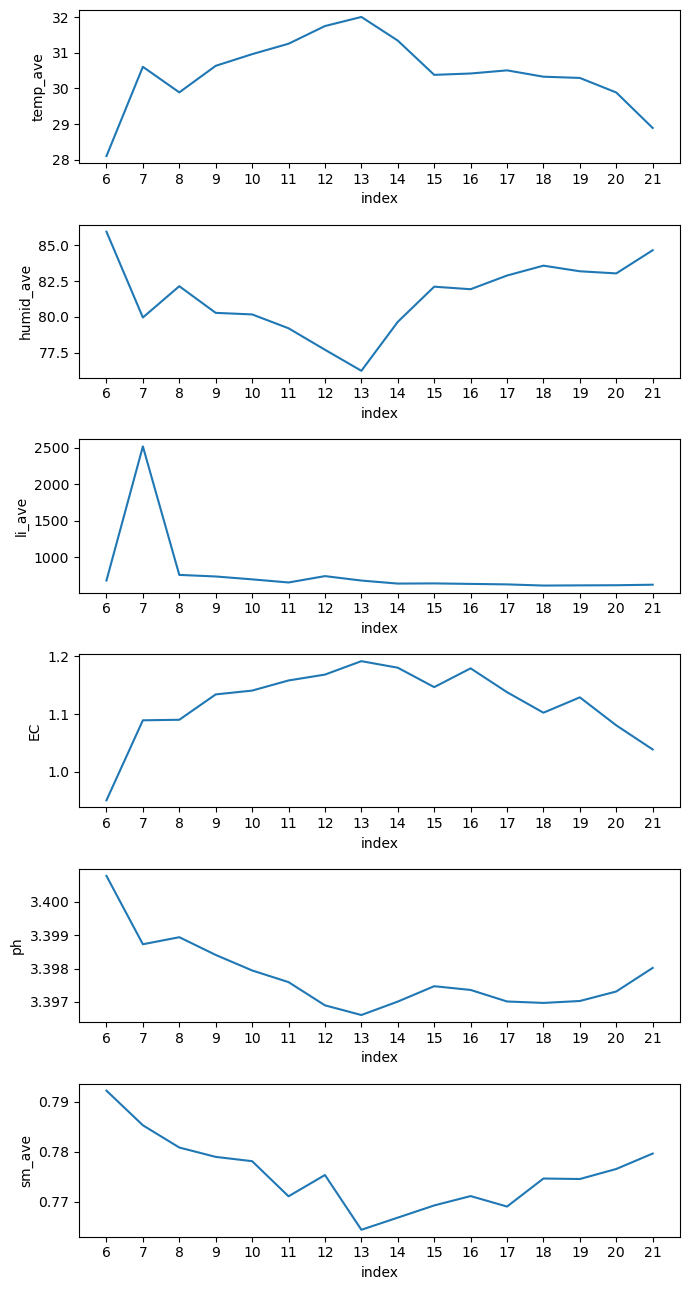

In [21]:
start_time = 6


fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(7,13))

for i, col in enumerate(ave_df_day.columns):
    ax[i].plot(range(start_time,start_time+hrs_per_day), ave_df_day.iloc[:,i].values, label=col)
        
    ax[i].set_xlabel('index')
    ax[i].set_ylabel(col)
    # ax[i].set_xticks(range(hrs_per_day));
    ax[i].set_xticks(range(6,6+hrs_per_day));
    

    
plt.tight_layout()
# plt.legend()
# plt.xticks(range(1,25));
plt.show()

fig.savefig('features_plot.png')

## extrapolation training

In [22]:
from sklearn.svm import SVR

from sklearn.metrics import mean_absolute_percentage_error # MAPE
from sklearn.metrics import mean_squared_error # MSE

### SVR

In [23]:
y_train.head()

,ph,sm_ave
0,3.400770,0.792215
1,3.398726,0.785291
2,3.398937,0.780842
3,3.398407,0.778968
4,3.397943,0.778113


## setup data

In [33]:
# svr = SVR()

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [25]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

svr_regr = make_pipeline(MinMaxScaler(), SVR())
svr_regr.fit(X_train, y_train.iloc[:, 1])

Pipeline(steps=[('minmaxscaler', MinMaxScaler()), ('svr', SVR())])

In [26]:
y_pred_svr = svr_regr.predict(X_test.values)


svr_mape = mean_absolute_percentage_error(y_pred_svr,  y_test.iloc[:, 1])

print("MAPE: ",svr_mape*100,"%")

MAPE:  6.402965590470186 %


/Users/admin/opt/anaconda3/envs/deeplearn/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


 ## LR 

In [27]:
from sklearn.linear_model import LinearRegression

lr_regr = make_pipeline(MinMaxScaler(),LinearRegression())
lr_regr.fit(X_train,  y_train.iloc[:, 1])

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('linearregression', LinearRegression())])

In [28]:
y_pred_lr = lr_regr.predict(X_test)
lr_mape = mean_absolute_percentage_error(y_pred_lr,  y_test.iloc[:, 1])
print("nutrient sol MAPE: ",lr_mape*100,"%")

nutrient sol MAPE:  5.597568719208462 %


## soil moist

In [34]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

svr_regr = make_pipeline(MinMaxScaler(), SVR())
svr_regr.fit(X_train, y_train.iloc[:, 0])

Pipeline(steps=[('minmaxscaler', MinMaxScaler()), ('svr', SVR())])

In [37]:
y_pred_svr = svr_regr.predict(X_test)

svr_mape = mean_absolute_percentage_error(y_pred_svr, y_test.iloc[:, 0])
print("sm MAPE: ",svr_mape*100,"%")

sm MAPE:  13.688166972239912 %


## LR sm mape

In [38]:
from sklearn.linear_model import LinearRegression

lr_regr = make_pipeline(MinMaxScaler(),LinearRegression())
lr_regr.fit(X_train, y_train.iloc[:, 0])

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('linearregression', LinearRegression())])

In [40]:
y_pred_lr = lr_regr.predict(X_test)

lr_mape = mean_absolute_percentage_error(y_pred_lr,  y_test.iloc[:, 0])
print("MAPE: ",lr_mape*100,"%")

MAPE:  11.996724402599689 %


In [42]:
import joblib
# save the model to disk
filename = 'model_ph.sav'
# joblib.dump(lr_regr, filename)

['model_ph.sav']